In [1]:
from time import time

t0 = time()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import soundfile as sf
import os
import librosa
import numpy as np
import glob
import pandas as pd

In [3]:
def get_features(file_name):

    if file_name: 
        X, sample_rate = sf.read(file_name, dtype='float32')
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T,axis=0)
    return mfccs_scaled

def extract_features():

    sub_dirs = os.listdir('ESC-10/audio')
    sub_dirs.sort()
    features_list = []
    for label, sub_dir in enumerate(sub_dirs):  
        for file_name in glob.glob(os.path.join('ESC-10/audio',sub_dir,"*.wav")):
            print("Extracting file ", file_name)
            try:
                mfccs = get_features(file_name)
            except Exception as e:
                print("Extraction error")
                continue
            features_list.append([mfccs,label])

    features_df = pd.DataFrame(features_list,columns = ['feature','class_label'])
    print(features_df.head())    
    return features_df

In [4]:
print("Extracting features..")
features_df = extract_features()

Extracting features..
                                             feature  class_label
0  [-309.30853, 88.03026, 1.5384002, 14.649376, -...            0
1  [-309.30853, 88.03026, 1.5384002, 14.649376, -...            0
2  [-281.61264, 103.59526, -8.473426, 7.9012995, ...            0
3  [-281.61264, 103.59526, -8.473426, 7.9012995, ...            0
4  [-324.52615, -3.5978088, -57.639755, 6.270338,...            0


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [6]:
def train(model,X_train, X_test, y_train, y_test,model_file):    
    
    model.compile(loss = 'categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    print(model.summary())

    print("training for 200 epochs with batch size 32")
   
    model.fit(X_train,y_train,batch_size= 32, epochs = 200, validation_data=(X_test,y_test))
    
    print("Saving model to disk")
    model.save(model_file)

def compute(X_test,y_test,model_file):

    loaded_model = load_model(model_file)
    score = loaded_model.evaluate(X_test,y_test)
    return score[0],score[1]*100

def predict(filename,le,model_file):

    model = load_model(model_file)
    prediction_feature = get_features(filename)
    if model_file == "trained_mlp.h5":
        prediction_feature = np.array([prediction_feature])

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector)
    print("Predicted class",predicted_class[0])
    predicted_proba_vector = model.predict_proba([prediction_feature])

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [7]:
def create_mlp(num_labels):

    model = Sequential()
    model.add(Dense(256,input_shape = (40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    return model

In [8]:
def get_numpy_array(features_df):

    X = np.array(features_df.feature.tolist())
    y = np.array(features_df.class_label.tolist())
    # encode classification labels
    le = LabelEncoder()
    # one hot encoded labels
    yy = to_categorical(le.fit_transform(y))
    return X,yy,le

def get_train_test(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
    return  X_train, X_test, y_train, y_test

In [9]:
#convert into numpy array
X, y, le = get_numpy_array(features_df)

# split into training and testing data
X_train, X_test, y_train, y_test = get_train_test(X,y)
num_labels = y.shape[1]

# create model architecture
model = create_mlp(num_labels)

# train model
print("Training..")
train(model,X_train, X_test, y_train, y_test,"trained_mlp.h5")


Training..
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)     

In [10]:
test_loss, test_accuracy = compute(X_test,y_test,"trained_mlp.h5")
print("Test loss",test_loss)
print("Test accuracy",test_accuracy)
print("time taken :", time() - t0)

4/4 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.9167
Test loss 0.37863901257514954
Test accuracy 91.66666865348816
time taken : 38.15469574928284


In [11]:

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[23  0  0  5  0]
 [ 0 21  1  2  0]
 [ 0  0 19  0  0]
 [ 0  0  2 21  0]
 [ 0  0  0  0 26]]


In [12]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Baby cry','Clock Alarm', 'Glass breaking','Tap open','Door knock']))


Classification Report

                precision    recall  f1-score   support

      Baby cry       1.00      0.82      0.90        28
   Clock Alarm       1.00      0.88      0.93        24
Glass breaking       0.86      1.00      0.93        19
      Tap open       0.75      0.91      0.82        23
    Door knock       1.00      1.00      1.00        26

      accuracy                           0.92       120
     macro avg       0.92      0.92      0.92       120
  weighted avg       0.93      0.92      0.92       120



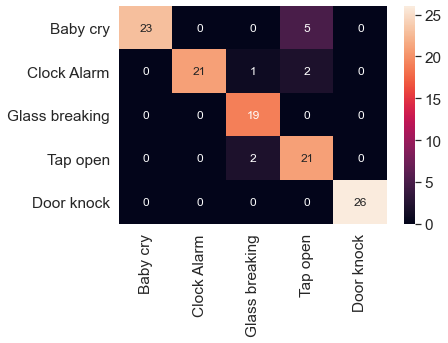

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[23,  0,  0,  5,  0],
 [ 0, 21,  1,  2,  0],
 [ 0,  0, 19,  0,  0],
 [ 0,  0,  2, 21,  0],
 [ 0,  0,  0,  0, 26]]
target_names=['Baby cry','Clock Alarm', 'Glass breaking','Tap open','Door knock']
df_cm = pd.DataFrame(array,target_names,target_names)
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})

plt.show()